In [405]:
import os
import sys
import json
import torch
import importlib
import matplotlib.pyplot as plt
import pandas as pd
# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

import src.utils
importlib.reload(src.utils)
from src.utils import calculate_sum_rate_sc

import src.sc_wmmse
importlib.reload(src.sc_wmmse)
from src.sc_wmmse import WMMSE_alg_sc

In [ ]:
## Initialize V according to zero force
# def initialize_V_zf(H_dict, d_list, P_T):
#     K = len(H_dict)
#     N_t = H_dict['0'].shape[1]

#     H = torch.cat([H_dict[str(k)] for k in range(K)], dim=0)  # shape (D, N_t)

#     H_herm = H.conj().T
#     HH_inv = torch.linalg.pinv(H @ H_herm)
#     V_zf = H_herm @ HH_inv  # shape (N_t, D)

#     # Global normalization
#     power_total = torch.norm(V_zf, p='fro')**2
#     V_zf_scaled = V_zf * torch.sqrt(P_T / power_total)

#     # Split V_zf into per-user blocks
#     V_dict = {}
#     stream_idx = 0
#     for k in range(K):
#         dk = d_list[k]
#         V_k = V_zf_scaled[:, stream_idx:stream_idx + dk]
#         V_dict[str(k)] = V_k
#         stream_idx += dk

#     return V_dict

/var/folders/35/f3dbnk6d3ts1993_z878dt5w0000gn/T/ipykernel_5311/3587116293.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alph = torch.sqrt(torch.tensor(P_T_sc)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(num_users_sc)])))
/Users/Ali/Projects/Deep-Unfolding-NN/src/sc_wmmse.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alph = torch.sqrt(torch.tensor(self.PT)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(self.K)])))


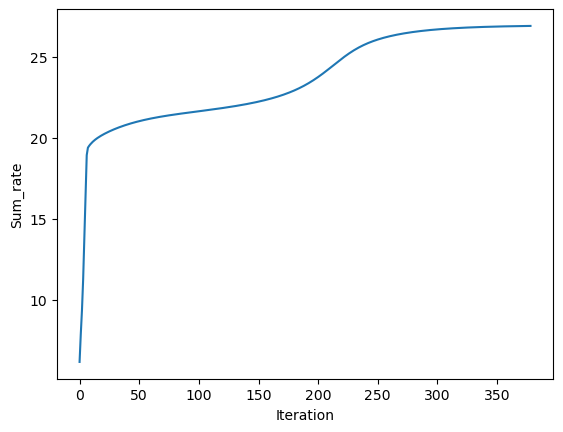

In [406]:
# The setup
num_users_sc = 10
n_tx_sc = 4
n_rx_sc = [2] * num_users_sc
num_streams_sc = [2] * num_users_sc
P_T_sc = 100
sig_k_sc = [1] * num_users_sc
d_sc = [2] * num_users_sc
alpha_sc = [1] * num_users_sc
max_iter_alg_sc = 500
tol_alg_sc = 1e-3
H_dict_sc = {}

# Sample H
H_dict_sc = {str(k): torch.randn(n_rx_sc[k], n_tx_sc, dtype=torch.cdouble) for k in range(num_users_sc)}

def proj_power(V):
    # Projects V according to the constraint
    alph = torch.sqrt(torch.tensor(P_T_sc)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(num_users_sc)])))
    V_proj = {str(k): alph * V[str(k)] for k in range(num_users_sc)}
    return V_proj

def init_V(H):
    # Initializes V according to Hu's code
    V = {}
    for k in range(len(H_dict)):
        V[str(k)] = (torch.linalg.pinv(H[str(k)] @ H[str(k)].conj().T) @ H[str(k)]).conj().T
    return V

# Initialize V
V_init_sc = init_V(H_dict_sc)

# Project V
V_proj_sc = proj_power(V_init_sc)

# Run the WMMSE algorithm
w = WMMSE_alg_sc(num_users_sc, n_tx_sc, n_rx_sc, H_dict_sc, P_T_sc, sig_k_sc, d_sc, alpha_sc, max_iter_alg_sc, tol_alg_sc)
V_l_sc, U_l_sc, W_l_sc = w.algorithm(V_proj_sc)

# r_l_sc = []
# for i in V_l_sc:
#     r_l_sc.append(calculate_sum_rate_sc(H_dict_sc, i, alpha_sc, sig_k_sc))
# plt.plot(r_l_sc)

# Plot sum rate vs iteration
W_l_l = []
for i in W_l_sc:
    val1 = 0
    for k in range(num_users_sc):
        val1 += torch.log2(torch.linalg.det(i[str(k)]))
    W_l_l.append(val1)
plt.plot(W_l_l)
plt.xlabel("Iteration")
plt.ylabel("Sum_rate")
plt.show()